In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Input, layers

print(tf.__version__)

2.15.0


In [2]:
load_saved_model = False
save_model  = False
EPOCHS = 10
# saved_model_path = 'saved_models/cifar_cnn_model'
saved_model_path = 'saved_models/cifar_cnn_model_06feb2024'
tfl_file_name = saved_model_path + '.tflite'

use_model_func = True

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

input_shape = train_images.shape[1:]
train_images = train_images / 255.0
test_images = test_images / 255.0
print("Training Images range from {:2.5f} to {:2.5f}".format(np.min(train_images), np.max(train_images)))
print("Test     Images range from {:2.5f} to {:2.5f}".format(np.min(test_images), np.max(test_images)))

Training Images range from 0.00000 to 1.00000
Test     Images range from 0.00000 to 1.00000


In [4]:
def conv_block(num_channels=32, kernel_size=(3,3), pool_size=(1,1),
               padding='same', drop_rate=None, activation='relu',
               use_batchnorm=False):
  def conv_blk_func(inputs):
    x = layers.Conv2D(num_channels, kernel_size=kernel_size, padding=padding)(inputs)
    if use_batchnorm:
      x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    if pool_size != (1,1) and pool_size != 1:
      x = layers.MaxPooling2D(pool_size=pool_size)(x)
    if drop_rate is not None:
      x = layers.Dropout(drop_rate)(x)
    return x
  return conv_blk_func


def build_model(input_shape, model_config):
  inputs = Input(shape=input_shape)
  x = inputs
  for idx in range(len(model_config['conv_num_channels'])):
    x = conv_block(num_channels=model_config['conv_num_channels'][idx], 
                   kernel_size=model_config['conv_kernel_sizes'][idx], 
                   pool_size=model_config['conv_pool_sizes'][idx], 
                   drop_rate=model_config['conv_drop_rates'][idx], 
                   use_batchnorm=model_config['conv_use_batchnorm'][idx])(x)

  if model_config['final_pool'] == 'average':
    x = layers.GlobalAveragePooling2D()(x)
  elif model_config['final_pool'] == 'max':
    x = layers.GlobalMaxPooling2D()(x)
  else:    
    x = layers.Flatten()(x)
  
  for idx in range(len(model_config['dense_sizes'])):
    x = layers.Dense(model_config['dense_sizes'][idx])(x)
    if model_config['dense_batchnorm'][idx]:
      x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if model_config['dense_droprates'][idx] is not None:
      x = layers.Dropout(model_config['dense_droprates'][idx])(x)
    
  x = layers.Dense(model_config['num_classes'])(x) # can't dropout last layer
  
  model = tf.keras.models.Model(inputs=inputs, outputs=x)
  
  return model 



In [5]:
if not load_saved_model and use_model_func:
  print(f"Building model from config")
  model_config = {'conv_num_channels':[32, 64, 128],
                 'conv_kernel_sizes':3*[3],
                 'conv_pool_sizes':[2, 2, 2],
                 'conv_drop_rates':3*[.25],
                 'conv_use_batchnorm':4*[True],
                 'dense_sizes':[],        #, [128],
                 'dense_droprates':[],    # [0.25],
                 'dense_batchnorm':[],    # [True],
                 'final_pool': None,
                 'num_classes': 10,
               }
  
  model = build_model(input_shape=input_shape, model_config=model_config)
  
elif not load_saved_model:
  print("Building CNN Model from scratch.")
  model = tf.keras.Sequential([
    Input(shape=input_shape),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(32, kernel_size=(1,1), activation="relu", padding='same'),    
    layers.BatchNormalization(), # optional, but may help convergence  
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),    
    layers.Conv2D(64, kernel_size=(1,1), strides=(4,4), activation="relu", padding='same'),
    layers.BatchNormalization(), # optional, but may help convergence    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),        
    layers.Conv2D(64, kernel_size=(1,1), activation="relu", padding='same'),        
    layers.BatchNormalization(), # optional, but may help convergence      
    layers.MaxPooling2D(pool_size=(4, 4)), 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='relu'),
  ])
else:
  print("Loading pre-trained model from {:}".format(saved_model_path))
  model = tf.keras.models.load_model(saved_model_path)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])  

model.summary()

Building model from config


2024-02-13 15:52:39.535091: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-13 15:52:39.535127: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-13 15:52:39.535133: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-13 15:52:39.535174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-13 15:52:39.535190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0     

In [6]:
model.count_params()


114634

In [7]:
if not load_saved_model:
  print(f"Training model for {EPOCHS} epochs")
  train_hist = model.fit(train_images, train_labels, 
                         validation_data=(test_images, test_labels),
                         epochs=EPOCHS)
if save_model:
  print("Saving trained model to {:}".format(saved_model_path))
  model.save(saved_model_path)

Training model for 10 epochs
Epoch 1/10


2024-02-13 15:52:41.349603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 22s 13ms/step - loss: 1.4958 - accuracy: 0.4782 - val_loss: 1.7383 - val_accuracy: 0.4152
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0702 - accuracy: 0.6262 - val_loss: 1.6582 - val_accuracy: 0.4599
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9205 - accuracy: 0.6789 - val_loss: 0.8935 - val_accuracy: 0.6873
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8371 - accuracy: 0.7087 - val_loss: 1.4863 - val_accuracy: 0.5204
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7761 - accuracy: 0.7316 - val_loss: 0.9117 - val_accuracy: 0.6859
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7325 - accuracy: 0.7450 - val_loss: 0.7055 - val_accuracy: 0.7577
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6996 - accuracy: 0.7581 - val_loss: 0.8381 - val_accura

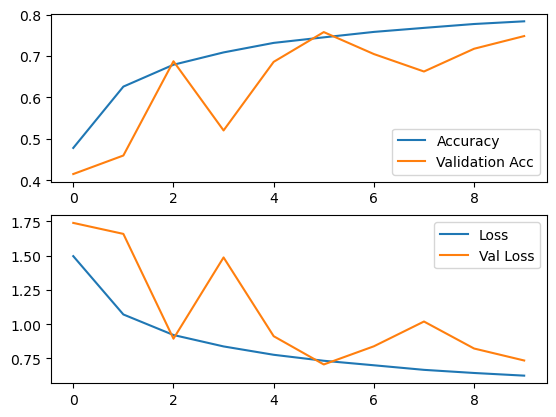

In [8]:
if not load_saved_model:
  plt.subplot(2,1,1)
  plt.plot(train_hist.epoch, train_hist.history['accuracy'], train_hist.epoch, train_hist.history['val_accuracy'])
  plt.legend(['Accuracy', 'Validation Acc'])
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['Loss', 'Val Loss'])

In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)


313/313 - 1s - loss: 0.7344 - accuracy: 0.7481 - 1s/epoch - 4ms/step


In [11]:
# model.layers[1].get_weights()[0]

In [12]:
restored_model = tf.keras.models.load_model(saved_model_path)
restored_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 32)        0   

## Convert to TFLite

In [14]:
num_calibration_steps = 25
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if True: 
  # If we omit this block, we'll get a floating-point TFLite model,
  # whose size in bytes should be ~4x the # parameters in the model
  # with this block, the weights and activations should be quantized to 8b integers, 
  # so the tflite file size (in bytes) will be ~ the number of model params, plus some overhead.

  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  def representative_dataset_gen():
    for i in range(num_calibration_steps):
      next_input = train_images[i:i+1,:,:,:]
      yield [next_input.astype(np.float32)] ## yield defines a generator

  converter.representative_dataset = representative_dataset_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # use this one
  # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

  converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
  converter.inference_output_type = tf.int8  # or tf.uint8

tflite_quant_model = converter.convert()

with open(tfl_file_name, "wb") as fpo:
  fpo.write(tflite_quant_model)
print(f"Wrote to {tfl_file_name}")
!ls -l $tfl_file_name

INFO:tensorflow:Assets written to: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpgsrdmlj5/assets


INFO:tensorflow:Assets written to: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpgsrdmlj5/assets
/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-13 15:56:02.980730: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-13 15:56:02.980749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.


Wrote to saved_models/cifar_cnn_model_06feb2024.tflite
-rw-r--r--  1 jeremy  staff  124152 Feb 13 15:56 saved_models/cifar_cnn_model_06feb2024.tflite


2024-02-13 15:56:02.981472: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpgsrdmlj5
2024-02-13 15:56:02.982857: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-13 15:56:02.982862: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpgsrdmlj5
2024-02-13 15:56:02.985749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-13 15:56:02.986682: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-13 15:56:03.031224: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpgsrdmlj5
2024-02-13 15:56:03.042526: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 

From a linux/mac command line, we can use `xxd -i` to convert the binary file into compileable  C code
```
xxd -i cifar_cnn_model_06feb2024.tflite # > cifar_cnn_model_06feb2024.cc
```
In this notebook, we'll leave off the redirect (`> output_file`) to just show the output.

In [34]:
!xxd -i quant_model.tflite # >! kws_model.cc


unsigned char quant_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00,
  0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x7c, 0x00, 0x00, 0x00, 0x70, 0x00, 0x00, 0x00,
  0xf0, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x98, 0x00, 0x00, 0x00,
  0x90, 0x00, 0x00, 0x00, 0x16, 0x00, 0x00, 0x00, 0xc0, 0x5f, 0x00, 0x00,
  0xbc, 0x5f, 0x00, 0x00, 0xe0, 0x5e, 0x00, 0x00, 0x68, 0x5e, 0x00, 0x00,
  0x04, 0x5e, 0x00, 0x00, 0xa0, 0x5d, 0x00, 0x00, 0x40, 0x5d, 0x00, 0x00,
  0xa4, 0x5f, 0x00, 0x00, 0x24, 0x5b, 0x00, 0x00, 0x70, 0x5a, 0x00, 0x00,
  0x98, 0x5f, 0x00, 0x00, 0x94, 0x5f, 0x00, 0x00, 0x90, 0x5f, 0x00, 0x00,
  0x8c, 0x5f, 0x00, 0x00, 0x9c, 0x55, 0x00, 0x00, 0x84, 0x5f, 0x00, 0x00,
  0x80, 0x5f, 0x00, 0x00, 0x7c, 0x5f, 0x00, 0x00, 0xbc, 0x02, 0x00, 0x00,
  0x74, 0x5f, 0x00, 0x00, 0x70, 0x5f, 0x00, 0x00, 0x6c, 0x00, 0x00, 0x00,

In [15]:
# model.summary()

In [16]:
interpreter = tf.lite.Interpreter(model_path=tfl_file_name)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
output_data = []
labels = []
input_scale, input_zero_point = input_details[0]["quantization"]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [17]:
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([ 1, 32, 32,  3], dtype=int32),
  'shape_signature': array([-1, 32, 32,  3], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [18]:
test_labels[0:5]

array([3, 8, 8, 0, 6], dtype=uint8)

In [19]:
i=0
dat = test_images[i:i+1,...]
dat.shape
dat_q = np.array(dat/input_scale + input_zero_point, dtype=np.int8)
print(f"min = {np.min(dat_q)}, max = {np.max(dat_q)}")

min = -115, max = 126


In [20]:
interpreter.set_tensor(input_details[0]['index'], dat_q)
interpreter.invoke()
out_vec = interpreter.get_tensor(output_details[0]['index'])
print(out_vec)

[[-27 -36   0  24 -26  10  11 -47 -23 -41]]


In [21]:
prediction = np.argmax(out_vec)
print(f"prediction = {prediction}, correct label = {test_labels[0]}")

prediction = 3, correct label = 3


In [22]:
output_data = []
labels = []
num_test_samples = 100
for i in range(num_test_samples):
  # dat, label in eval_data:
  dat = test_images[i:i+1,...]
  label = test_labels
  dat_q = np.array(dat/input_scale + input_zero_point, dtype=np.int8)
  
  interpreter.set_tensor(input_details[0]['index'], dat_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data.append(np.argmax(interpreter.get_tensor(output_details[0]['index'])))
  labels.append(test_labels[i])

num_correct = np.sum(np.array(labels) == output_data)
acc = num_correct / len(labels)
print(f"Accuracy = {acc:5.3f} ({num_correct}/{len(labels)})")


Accuracy = 0.760 (76/100)


In [23]:
# def predict(interpreter, data):

#   # Get input and output tensors.
#   input_details = interpreter.get_input_details()
#   output_details = interpreter.get_output_details()
  
#   # Test the model on input data.
#   input_shape = input_details[0]['shape']

#   input_data = np.array(data, dtype=np.int8)
#   output_data = np.empty_like(data)
  
#   interpreter.set_tensor(input_details[0]['index'], input_data[i:i+1, :])
#   interpreter.invoke() # actually runs inference on the model
#   # The function `get_tensor()` returns a copy of the tensor data.
#   # Use `tensor()` in order to get a pointer to the tensor.
#   output_data[i:i+1, :] = interpreter.get_tensor(output_details[0]['index'])
#   return output_data
  

## Why better after quantizing?

Sometimes, a model may perform better after quantizing.  Why is that?

* Answer 1: random noise
* Answer 2: quantization acting as regularizer.

Methods to get good accuracy with quantized weights:
1) Quantization-aware training.  Roughly, during training, quantize in forward pass, use floating points in the feedback pass. Store high-resolution value of the weights to hold the small updates until they accumulate sufficiently
2) Progressive Quantization:  Quantize 1st layer, then re-train following layers. 2nd layer can make up for errors in the 1st layer.  Repeat. 


Q: Can we use quantization combined with pruning (pruning: set the smallest weights to 0)?
Yes. 

In [31]:
pwd

'/Users/jeremy/dev/tiny_class_code/quantization'

In [32]:
np.maximum(2, 3)


3

In [33]:

print(tf.__version__)

2.15.0
